In [3]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import random
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

DATA_PATH = "../data"
VIS_PATH = "../visualisations"
model = spacy.load("en_core_web_trf")

c:\users\mathias\appdata\local\programs\python\python36\lib\site-packages\packaging\version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,


In [4]:
data = pd.read_pickle(DATA_PATH + "/processed/dataset+date_tokenized.pkl")
data.head()

,Contract,Title,Type of contract,Short description,Total value,Place of performance,Contractor,Notice dispatch date,Short description tokenized
0,000007-2017,Framework contract for the provision of passen...,SERVICES,Provision of passenger transfer services by bu...,150000.0,GR,[Vagia Tzislaki — Lesvorama General Travel Age...,2016-12-22,provision passenger transfer service bus greec...
1,000007-2017,Framework contract for the provision of passen...,SERVICES,Provision of passenger services by bus in Gree...,150000.0,GR,[Vagia Tzislaki — Lesvorama General Travel Age...,2016-12-22,provision passenger service bus greece chios i...
2,000007-2017,Framework contract for the provision of passen...,SERVICES,Framework contract for the provision of passen...,NaN,GR,None,2016-12-22,framework contract provision passenger transfe...
3,008449-2018,Provision of HID® FARGO® HDP5000 ID card print...,SUPPLIES,The subject of the contract is provision of HI...,190000.0,PL,[Control system FMN Sp z oo],2018-01-04,subject contract provision hid ® fargo ® hdp50...
4,008450-2018,Provision of painting services for Frontex,SERVICES,Provision of painting services for Frontex.,NaN,PL,None,2018-01-04,provision painting service frontex


## Tokenization

In [4]:
def tokenize(sample):
    if not sample:
        return None
    
    tokens = []
    doc = model(sample)
    for token in doc:
        if token.pos_ != "PUNCT":
            token_processed = token.lemma_.lower().strip()
        
            if token_processed not in STOP_WORDS:
                tokens.append(token_processed)        
    return " ".join(tokens)

In [28]:
# test tokenization
sample = data.sample()["Short description"].iloc[0]
print(sample)
print()
print(tokenize(sample))

Supply of handheld thermal cameras.

supply handheld thermal camera


In [5]:
# add a new column to the dataset, namely the tokenized versions of the short description
data["Short description tokenized"] = data["Short description"].apply(tokenize)
data.to_pickle(DATA_PATH + "/processed/dataset+date_tokenized.pkl")

## Preprocess data

In [5]:
# filter datapoints with invalid or missing descriptions
descriptions = data[data["Short description tokenized"].notna()].reset_index(drop=True)
tokenized_descriptions = descriptions["Short description tokenized"]

# vectorize data, that is create matrix of word count per document
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(tokenized_descriptions)

# total word counts
word_freq = [np.sum(data_vectorized.toarray()[:,index]) for index in range(len(vectorizer.get_feature_names()))]

In [93]:
# DELETE THIS
# Save visualisation as html for multiple k's
# for i in range(2, 11):
#     lda = LatentDirichletAllocation(n_components=i, learning_method='online')
#     data_lda = lda.fit_transform(data_vectorized)

#     # apparantly this is bugged in jupyterlab, but works in jupyter notebook
#     plot = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')

#     # export the graph as html
#     pyLDAvis.save_html(plot, VIS_PATH + '/lda_' + str(i) + '_topics.html')

## Find optimal hyperparameters

In [16]:
log_likelihoods = []
perplexities = []
coherences = []
ks = list(range(2, 50))
for i in ks:
    lda = LatentDirichletAllocation(n_components=i, learning_method='online')
    data_lda = lda.fit_transform(data_vectorized)
    
    coherence = metric_coherence_gensim(
        measure='u_mass',
        topic_word_distrib=lda.components_,
        dtm=data_vectorized.toarray(),
        vocab=np.array(vectorizer.get_feature_names())
    )
    coherences.append(np.mean(coherence))
    
    log_likelihoods.append(lda.score(data_vectorized))
    perplexities.append(lda.perplexity(data_vectorized))

3 highest log likelihoods: [-54970.37885831 -55643.18089363 -55758.90907504]
Associated k's: [12, 11, 9]


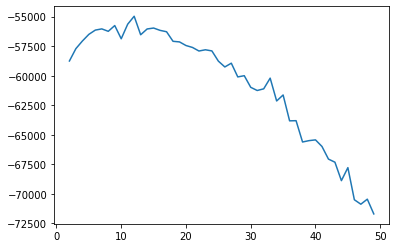

In [17]:
plt.plot(ks, log_likelihoods)

top_n = 3
print(f"{top_n} highest log likelihoods: {np.sort(log_likelihoods)[::-1][:top_n]}")
print(f"Associated k's: {[ks[i] for i in np.argsort(log_likelihoods)[::-1][:top_n]]}")

3 lowest perplexities: [365.5032751  392.87953893 397.79106302]
Associated k's: [12, 11, 9]


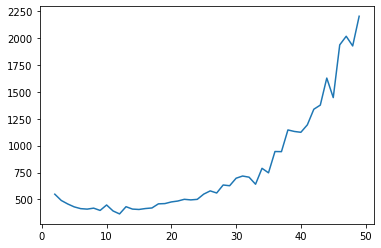

In [18]:
plt.plot(ks, perplexities)

top_n = 3
print(f"{top_n} lowest perplexities: {np.sort(perplexities)[:top_n]}")
print(f"Associated k's: {[ks[i] for i in np.argsort(perplexities)[:top_n]]}")

3 highest cv coherence: [-2.59054285 -3.85326053 -4.86677231]
Associated k's: [2, 4, 7]


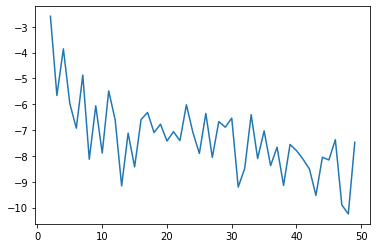

In [19]:
plt.plot(ks, coherences)

top_n = 3
print(f"{top_n} highest cv coherence: {np.sort(coherences)[::-1][:top_n]}")
print(f"Associated k's: {[ks[i] for i in np.argsort(coherences)[::-1][:top_n]]}")

## Optimal model

In [336]:
# LDA using optimal k
lda = LatentDirichletAllocation(n_components=10, learning_method='online')
lda.fit(data_vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [7]:
# transform data
data_lda = lda.transform(data_vectorized)

#### Save model

In [338]:
import pickle
MODELS_PATH = "../models"

with open(MODELS_PATH + "/scikitLDA10.pkl", "wb") as f:
    pickle.dump(lda, f)

#### Load model

In [6]:
import pickle
MODELS_PATH = "../models"

with open(MODELS_PATH + "/scikitLDA9.pkl", "rb") as f:
    lda = pickle.load(f)

## Visualize topics

In [8]:
plot = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne', sort_topics=False, )

# export the graph as html
# pyLDAvis.save_html(plot, VIS_PATH + '/scikitLDA7_plot.html')

# show plot
plot

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      -61.876961   62.040791       1        1  12.874006
1       58.314384  -19.816950       2        1   2.206649
2       26.729540   77.765854       3        1   4.559401
3      -11.237781   -2.648332       4        1   5.692407
4      137.439011  -39.396515       5        1  16.683709
5      107.388351   50.596363       6        1  23.544937
6      -15.124341  -91.477036       7        1  25.779337
7       68.902931 -104.990898       8        1   5.450415
8      -86.195625  -36.257202       9        1   3.209140, topic_info=              Term        Freq       Total Category  logprob  loglift
1062      software  155.000000  155.000000  Default  30.0000  30.0000
1036       service  283.000000  283.000000  Default  29.0000  29.0000
1119  surveillance   92.000000   92.000000  Default  28.0000  28.0000
485        frontex  204.000000  204.000000  Default  27.0000  27.0000
336    development   75.000000   75.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
80       amendment    2.093429    4.596973   Topic9  -4.9614   2.6526
790       organise    2.189902    7.058719   Topic9  -4.9164   2.2688
671            lot    4.672721   60.538993   Topic9  -4.1585   0.8776
691       maritime    3.378453   34.540531   Topic9  -4.4828   1.1145
146         border    2.348538   56.987909   Topic9  -4.8464   0.2501

[462 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1         5  0.150068   000
1         8  0.150068   000
1         9  0.600273   000
4         3  0.695701   100
4         5  0.298157   100
...     ...       ...   ...
1235      9  0.039408  work
1246      1  0.121091  year
1246      5  0.666000  year
1246      7  0.121091  year
1246      8  0.060545  year

[700 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
# name topics
topic_names_k7 = {
    1 : 'deployment?',
    2 : 'clothing/uniforms',
    3 : 'presentations/markets',
    4 : 'information systems',
    5 : 'local frontex operations',
    6 : 'software development',
    7 : 'surveillance'
}

topic_names_k9 = {
    1 : 'information systems',
    2 : 'local operational support',
    3 : 'organised events',
    4 : 'border control',
    5 : 'contract',
    6 : 'software development',
    7 : 'surveillance',
    8 : 'ground support/equipment',
    9 : 'clothing/uniforms',
}

topic_names_k11 = {
    1 : 'software development',
    2 : 'travel/location',
    3 : 'local frontex operation',
    4 : 'nautical charts/intranet?',
    5 : 'clothing/uniform',
    6 : 'organised events',
    7 : 'contract',
    8 : 'remote controlled vehicles?',
    9 : 'information systems',
    10 : 'border control',
    11 : 'surveillance',
}

topic_names = topic_names_k9

Document distribution


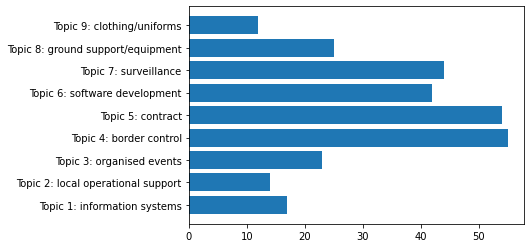

In [10]:
# docments per dominant topic
document_dist = []
for topic_n in range(len(data_lda[0])):
    n_docs = len([i for i, val in enumerate(data_lda) if np.argsort(val)[-1] == topic_n])
    document_dist.append(n_docs)
    
plt.barh([f"Topic {key}: {topic_names[key]}" for key in range(1,len(topic_names) + 1)], document_dist)
print("Document distribution")

In [13]:
def describe_doc(doc_id, plot=True):
    print("Description:")
    print(descriptions["Short description"].iloc[doc_id])

    sorted_topic = np.sort(data_lda[doc_id])[::-1]
    sorted_topic_index = np.argsort(data_lda[doc_id])[::-1]
    
    print("\nTopics (ranked):")
    topic_strings = []
    topic_weights = []
    for i in range(len(sorted_topic)):
        topic_n = sorted_topic_index[i] + 1
        topic_name = topic_names[topic_n]
        topic_weight = sorted_topic[i]
        
        if plot:
            topic_strings.append(f"Topic {topic_n}: {topic_names[topic_n]}")
            topic_weights.append(topic_weight)
        else:
            print(f"    Topic {topic_n}: {topic_name:<20}{topic_weight:20.9f}")

    if plot:
        plt.figure()
        plt.barh(
            topic_strings[::-1],
            topic_weights[::-1]
        )  

doc_id: 60
Description:
For the purpose of this contract, Maritime Analysis Tools is defined as a system that works with maritime ‘big data’ (e.g. maritime reporting systems data, information on ship ownership/management, historical movements of vessels, and relevant open source information). The system must be capable of producing information of interest for border/coast guard and law enforcement authorities by performing the following functions: (a) capturing, collecting, storing, searching, querying, visualization and updating maritime ‘big data’; (b) analysing, identifying/categorising high-risk threats, assessing maritime risks and informing policy and practice in this work area of the maritime domain; (c) performing analytical capabilities to research systematically the maritime risk environment and deliver a set of products, such as risk alerts/profiles, periodical strategic overviews, maritime area analyses and EU/regional risk maps.

Topics (ranked):


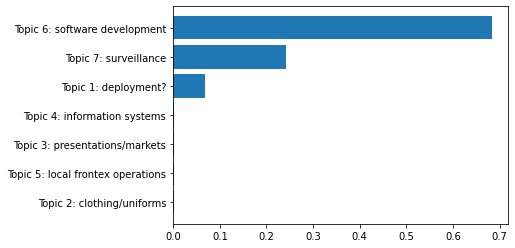

In [245]:
# Sample a random document and print topic
doc_id = np.random.randint(0, len(descriptions["Short description"]) - 1)
print(f"doc_id: {doc_id}")
describe_doc(7)

Topic: 2 - local operational support
Number of documents for this topic: 14

doc_id: 131
Description:
Provision of fuel cards and associated services for Frontex cars operating in Bulgaria.

Topics (ranked):


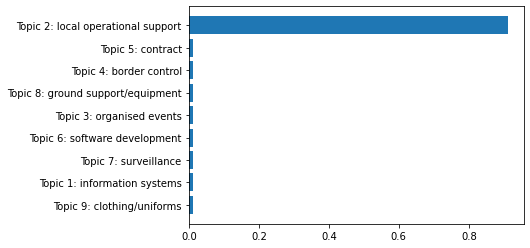

In [14]:
# For a given topic sample a random document
topic_n = 2
print(f"Topic: {topic_n} - {topic_names[topic_n]}")

# all documents with a given topic as dominant topic
topic_docs = [i for i, val in enumerate(data_lda) if np.argsort(val)[-1] == topic_n - 1]
print(f"Number of documents for this topic: {len(topic_docs)}\n")

# a random document of the given topic
for doc_id in random.sample(topic_docs, k=1):
    print(f"doc_id: {doc_id}")
    describe_doc(doc_id, plot=True)
    print("="*80)

## Topic distribution per year

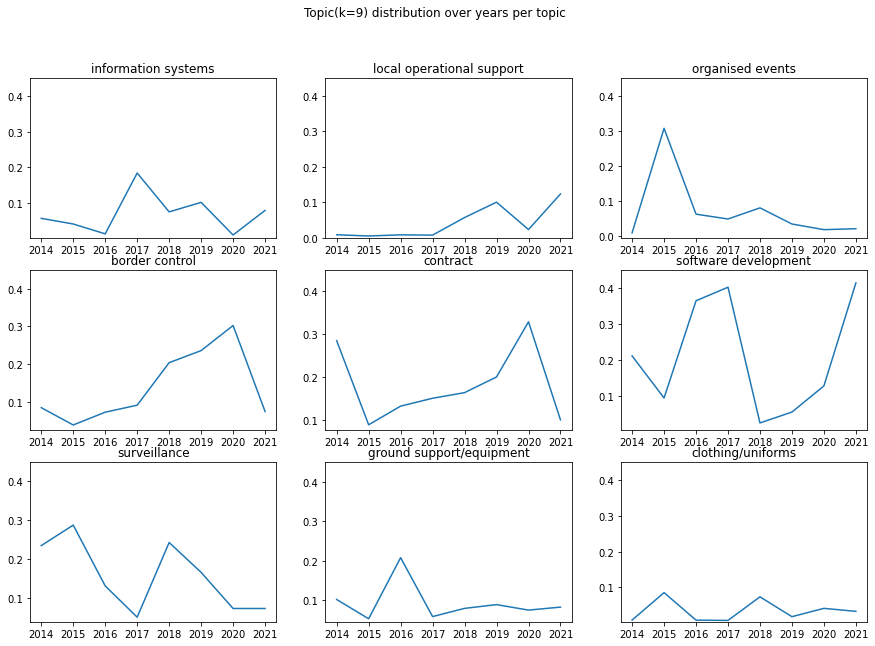

In [93]:
# create topic distribution per year
data = descriptions
topic_dist_years = []
for year in [str(y) for y in range(2014, 2022)]:
    ids = data[data["Notice dispatch date"].str.contains(year)].index
    topic_dist = np.mean(data_lda[ids], axis=0)
    topic_dist_years.append(topic_dist)
    
    
# plot the distribution of each topic over the years
fig = plt.figure(figsize = (15,10))
plt.suptitle("Topic(k=9) distribution over years per topic")
fig.tight_layout(pad=1.0)
for topic_index in range(len(data_lda[0])):
    plt.subplot(3,int(np.ceil(len(data_lda[0])/3)), topic_index+1)
    plt.plot(list(range(2014, 2022)), [x[topic_index] for x in topic_dist_years])
    plt.title(topic_names[topic_index+1])
    plt.ylim(top=0.45)

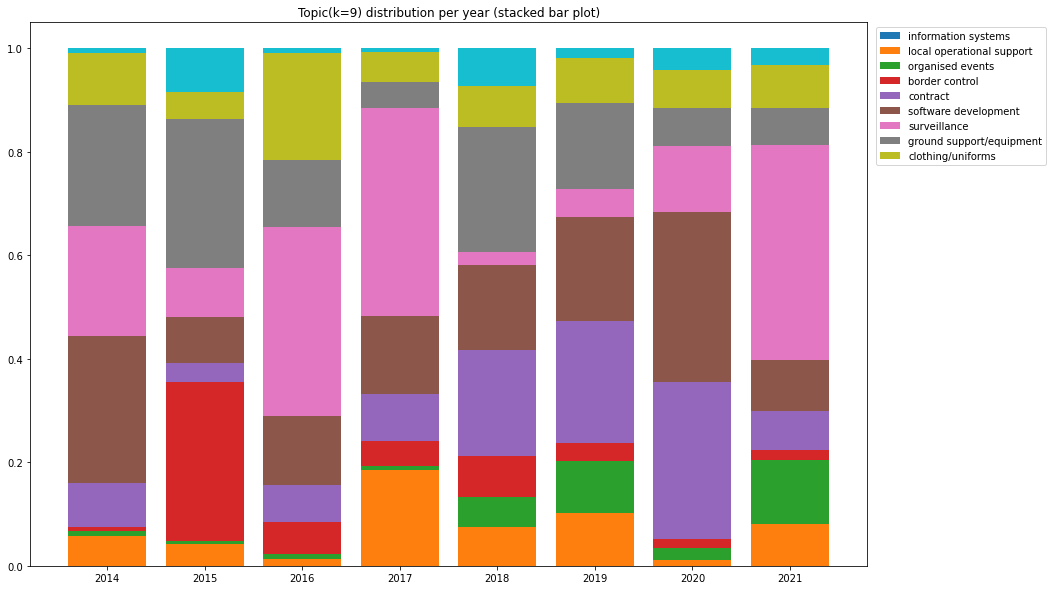

In [97]:
# stacked bar plot for yearly topic distribution
fig = plt.figure(figsize = (15,10))
plt.title("Topic(k=9) distribution per year (stacked bar plot)")
plt.bar(list(range(2014, 2022)), [x[0] for x in topic_dist_years])
for i in range(len(data_lda[0])):
    plt.bar(
        list(range(2014, 2022)),
        [x[i] for x in topic_dist_years], 
        bottom=np.sum([[x[y] for x in topic_dist_years] for y in range(0,i)], axis=0)
    )
plt.legend(topic_names.values(), loc=1, bbox_to_anchor=(1.22, 1))